## Understanding the E91 Quantum Key Distribution Protocol

Quantum Key Distribution (QKD) ensures secure communication by using the principles of quantum mechanics. One of the most well-known QKD protocols is *E91, proposed by Artur Ekert in 1991. It leverages *quantum entanglement* and *Bell's theorem* to ensure that any attempt at eavesdropping can be detected.

### What is the E91 Protocol?

The *E91 protocol* uses *entangled quantum particles* to allow two parties (commonly known as Alice and Bob) to generate a shared, secret cryptographic key. It differs from earlier QKD protocols like BB84 by using *entanglement* instead of individually prepared quantum states.   
The security of E91 is guaranteed by the *CHSH inequality* — a testable condition from quantum mechanics. Any deviation from the expected quantum correlations signals potential *eavesdropping*.


<p align="center">
  <img src="Figures/E91/image.png" alt="E91 Diagram" width="600">
</p>


### How the E91 Protocol Works: Step-by-Step

1. *Entanglement Source:*
   - A *quantum entangled photon source* (shown in the center of the diagram) emits entangled photon pairs in the Bell state:
     $$
     |\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
     $$
   - One photon from each pair is sent to *Alice* (left side of the image), and the other to *Bob* (right side).

2. *Random Basis Selection:*
   - *Alice* and *Bob* each randomly select one of *three measurement angles*:
     - Alice uses measurement angles:  
       $$
       \phi^a_i = \left\{0, \frac{\pi}{4}, \frac{\pi}{2} \right\}
       $$
     - Bob uses measurement angles:  
       $$
       \phi^b_j = \left\{ \frac{\pi}{4}, \frac{\pi}{2}, \frac{3\pi}{4} \right\}
       $$
   - These correspond to quantum observables constructed from Pauli matrices:
     $$
     W = \frac{X + Z}{\sqrt{2}}, \quad V = \frac{-X + Z}{\sqrt{2}}
     $$

3. *Quantum Measurement:*
   - Each photon is measured along the chosen direction (represented by the lines going to detectors).
   - Outcomes are either *+1 or -1*, corresponding to spin or polarization directions.

4. *Basis Announcement:*
   - After all measurements are done, Alice and Bob *publicly announce* which angles (measurement bases) they used — *not the results*.
   - This step is reflected after the detectors and leads into *information processing* .

5. *Key Sifting:*
   - Only outcomes where their chosen bases are *compatible* (i.e., expected to be strongly correlated) are kept to form the *raw key*.

6. *CHSH Inequality Test (Security Check):*
   - A subset of results (where different bases were used) is used to compute the *CHSH parameter*:
     $$
     \langle S \rangle = \langle Z \otimes W \rangle + \langle Z \otimes V \rangle + \langle X \otimes W \rangle - \langle X \otimes V \rangle
     $$
     - *Classical limit:*
       $$
       |\langle S \rangle| \leq 2
       $$
     - *Quantum prediction:*
       $$
       |\langle S \rangle| = 2\sqrt{2}
       $$
   - If the observed value exceeds 2, it confirms *entanglement* and the *absence of eavesdropping*.

7. *Error Correction & Privacy Amplification:*
   - The IP block performs *error correction* to fix mismatches and *privacy amplification* to remove any leaked information.
   - The final output is a *shared, secret key* — secure even in the presence of potential eavesdropping.


## E91 Protocol Overview : 

<p align="center">
  <img src="Figures/E91/E91.png" alt="E91 Diagram" width="800">
</p>


In [1]:
# E91 Quantum Key Distribution Simulator
# Comprehensive simulation framework for E91 protocol over different channel types

# ========================== Import Libraries ==========================
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import math
from math import cos, sin, pi, sqrt, log2, exp,sinh
from enum import Enum
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

## 2. Simulation Components

### 2.1 SPDC Type-II Source

In entanglement-based QKD protocols like E91, we utilize spontaneous parametric down-conversion (SPDC) sources instead of ideal entangled photon pair sources. Specifically, a Type-II SPDC source emits polarization-entangled photon pairs into distinct spatial modes, making it suitable for performing Bell inequality tests central to the E91 protocol.

To model the pair generation statistics of the SPDC-2 source, we assume the number of generated photon pairs per pulse follows a Poisson distribution with mean pair number mu . The probability P(n) of generating exactly  n  photon pairs is given by:

$$
P(n) = \frac{\mu^n e^{-\mu}}{n!}
$$

This distribution is used in the simulation to account for multi-pair events, which can affect both the bell inequality (S) and the resulting quantum bit error rate (QBER).




In [2]:
class PhotonSource:
    def __init__(self, mu):
        self.mu = mu

    def photon_distribution(self, n_max=20):
        n_values = np.arange(n_max + 1)
        p_s = np.exp(-self.mu)*(self.mu**n_values)/np.array([math.factorial(n)for n in n_values])
        return p_s

## 2.2 Channel Class

- Simulates a **quantum channel**: Optical Fiber or Free Space Optical (FSO)
- Accepts **user-defined parameters** such as attenuation, time window, detector efficiency, and source power  
- Computes **total noise probability** from all sources: dark counts, Raman scattering (fiber), and stray light (FSO)  


###  Fiber Channel

- **Transmittance** decreases exponentially with distance:  
  $$
  \eta = 10^{- \alpha L / 10}
  $$  
  where:
  - $ \alpha $: attenuation in dB/km  
  - $ L $: channel length in km  

- **Raman Noise** included:
  - **Forward Raman scattering**:  
    $$
    P_{\text{raman,f}} = N_f \cdot P_{\text{out}} \cdot L \cdot \rho \cdot \Delta\lambda
    $$
  - **Backward Raman scattering**:  
    $$
    P_{\text{raman,b}} =
    \begin{cases}
    N_b \cdot P_{\text{out}} \cdot \frac{\sinh(\alpha L)}{\alpha} \cdot \rho \cdot \Delta\lambda & \text{if } \alpha \neq 0 \\
    N_b \cdot P_{\text{out}} \cdot L \cdot \rho \cdot \Delta\lambda & \text{(fallback)}
    \end{cases}
    $$
  - **Photon probability**:
    $$
    p_{\text{raman}} = \frac{P_{\text{raman}} \cdot \Delta t \cdot \eta_d}{E_{\text{photon}}}
    $$

- **Dark Count Noise** modeled as:  
  $$
  p_{\text{dark}} = 1 - e^{-D \cdot \Delta t}
  $$
  where:
  - $ D $ : dark count rate (Hz)  
  - $ \Delta t $ : time window (s)  



###  FSO Channel

- **Transmittance** includes geometric and atmospheric losses:
  $$
  \eta = \left( \frac{d_r}{d_t + \theta L} \right)^2 \cdot \exp(-\alpha L)
  $$
  where:
  - $  d_t $ : transmitter aperture  
  - $  d_r $ : receiver aperture  
  - $  \theta $ : beam divergence (rad)  
  - $  \alpha $ : atmospheric loss (1/km)  
  - $  L $ : distance (km)  

- **Stray Light Noise**:
  - Power from background radiance:  
    $$
    P_{\text{stray}} = B_\lambda \cdot A \cdot \omega \cdot \Delta\lambda \cdot \eta_r
    $$
   where $A = \pi (d_r/2)^2$
  - Converted to photon count:  
    $$
    p_{\text{stray}} = \frac{P_{\text{stray}} \cdot \Delta t \cdot \eta_d}{E_{\text{photon}}}
    $$

- **Dark Count Noise** modeled the same way as in fiber



###  Noise Summary

- **Total noise probability**:  
  $$
  p_{\text{total}} = \sum p_{\text{noise components}}
  $$

- **Noise components include**:
  - Fiber: `{raman_forward, raman_backward, dark}`  
  - FSO: `{stray, dark}`


  ## Channel Overview :

<p align="center">
  <img src="Figures/E91/channel2.png" alt="E91 Diagram" width="1200">

</p>




In [3]:
# ========================== Channel Class ==========================
class ChannelType(Enum):
    FIBER = "fiber"
    FSO = "fso"  # Free Space Optical

from enum import Enum
from typing import Dict
from math import pi, exp
from scipy.constants import h, c  # Planck's constant and speed of light

class ChannelType(Enum):
    FIBER = "fiber"
    FSO = "fso"  # Free Space Optical

class QuantumChannel:
    """
    Quantum channel class supporting both fiber and FSO transmission
    """
    def __init__(self, channel_type: ChannelType, **kwargs):
        self.channel_type = channel_type
        self.user_params = kwargs  # Store user-defined parameters
        self._set_channel_parameters()

    def compute_dark_prob(self, dark_count_rate, time_window):
        """Compute probability of at least one dark count in a time window"""
        return 1 - exp(-dark_count_rate * time_window)
    
    def _set_channel_parameters(self):
        # Common dark count and window parameters (user-defined)
        dark_count_rate = self.user_params.get('dark_count_rate', 5000)  # Hz
        time_window = self.user_params.get('time_window', 1e-9)          # seconds
        p_dark = self.compute_dark_prob(dark_count_rate, time_window)


        """Set channel-specific parameters"""
        if self.channel_type == ChannelType.FIBER:
            self.alpha_db = self.user_params.get('alpha_db', 0.2)  # dB/km
            self.alpha_linear = self.alpha_db / 4.343               # 1/km
            self.max_distance = self.user_params.get('max_distance', 300)
            self.distance_km = self.user_params.get('distance_km', self.max_distance)

            # Raman parameters (user-defined or default)
            P_in = self.user_params.get('P_in', 1e-6)  # Input classical power [W]
            delta_lambda = self.user_params.get('delta_lambda', 0.7)  # nm
            rho = self.user_params.get('rho', 2e-9)   # Raman cross section [nm⁻¹·km⁻¹]
            eta_d = self.user_params.get('eta_d', 0.6)  # detector QE
            delta_t = self.user_params.get('delta_t', 1e-9)  # detection window [s]
            wavelength_nm = self.user_params.get('wavelength_nm', 1550)  # detection λ
            N_f = self.user_params.get('N_f', 2.0)  # scaling for forward scattering
            N_b = self.user_params.get('N_b', 2.0)  # scaling for backward scattering

            L = self.distance_km
            alpha = self.alpha_linear
            frequency = c / (wavelength_nm * 1e-9)
            E_photon = h * frequency

            # Outgoing classical power
            P_out = P_in * exp(-alpha * L)

            # Forward Raman power
            P_raman_f = N_f * P_out * L * rho * delta_lambda

            # Backward Raman power
            if alpha != 0:
                P_raman_b = N_b * P_out * (sinh(alpha * L) / alpha) * rho * delta_lambda
            else:
                P_raman_b = N_b * P_out * L * rho * delta_lambda  # fallback if lossless

            # Convert to photon count probabilities
            p_raman_f = (P_raman_f * delta_t * eta_d) / E_photon
            p_raman_b = (P_raman_b * delta_t * eta_d) / E_photon

            self.noise_components = {
                'raman_forward': p_raman_f,
                'raman_backward': p_raman_b,
                'dark': p_dark
            }

        
        elif self.channel_type == ChannelType.FSO:
            self.alpha_db = self.user_params.get('alpha_db', 0.1)   # dB/km
            self.max_distance = self.user_params.get('max_distance', 50)
            self.beam_divergence = self.user_params.get('beam_divergence', 0.025e-3)  # radians
            self.tx_aperture = self.user_params.get('tx_aperture', 0.01)  # meters
            self.rx_aperture = self.user_params.get('rx_aperture', 0.03)  # meters

            # Stray light parameters (user-defined or default)
            B_lambda = self.user_params.get('B_lambda', 1e-3)           # (sky radiance)W/nm/m²/sr
            delta_lambda = self.user_params.get('delta_lambda', 0.5)     # (Bandwidth)nm
            omega = self.user_params.get('omega', 1e-8)                 # Field of view (sr)
            eta_d = self.user_params.get('eta_d', 0.6)                  # quantum efficiency
            delta_t = self.user_params.get('delta_t', 1e-9)             # s
            wavelength_nm = self.user_params.get('wavelength_nm', 800) # nm
            eta_r = self.user_params.get('eta_d', 0.9)    

            stray_noise = self.compute_stray_noise(B_lambda, delta_lambda,
                                                   omega, eta_d, delta_t,
                                                   wavelength_nm,eta_r)

            self.noise_components = {
                'stray': stray_noise,
                'dark': p_dark
            }
        
        # Convert dB/km to 1/km for use in exp-based model
        self.alpha_linear = self.alpha_db / 4.343
        self.total_noise_prob = sum(self.noise_components.values())

    def compute_stray_noise(self, B_lambda: float, delta_lambda: float,
                            omega: float, eta_d: float, delta_t: float,
                            wavelength_nm: float,eta_r:float) -> float:
        """
        Compute stray photon probability per detection window.

        Returns:
            Stray photon count per window (dimensionless)
        """
        area = pi * (self.rx_aperture / 2) ** 2  # Aperture area in m²
        frequency = c / (wavelength_nm * 1e-9)   # Convert nm to Hz
        power = B_lambda * area * omega * delta_lambda * eta_r  # Power in W
        return (power *delta_t*eta_d ) / (h * frequency)  # Photon count

    def transmittance(self, distance_km: float) -> float:
        """
        Calculate channel transmittance for given distance
        """
        if self.channel_type == ChannelType.FIBER:
            return 10 ** (-self.alpha_db * distance_km / 10)
        
        elif self.channel_type == ChannelType.FSO:
            distance_m = distance_km * 1000
            geo_loss = (self.rx_aperture / (self.tx_aperture + self.beam_divergence * distance_m)) ** 2
            atm_loss = exp(-self.alpha_linear * distance_km)
            return geo_loss * atm_loss

    def get_channel_info(self) -> Dict:
        """Return channel configuration information"""
        return {
            'type': self.channel_type.value,
            'alpha_db': self.alpha_db,
            'max_distance': self.max_distance,
            'noise_components': self.noise_components,
            'total_noise': self.total_noise_prob
        }

    def update_parameters(self, **kwargs):
        """Update parameters and recompute noise if needed"""
        self.user_params.update(kwargs)
        self._set_channel_parameters()



## 2.3 Quantum Detection Theory

### Understanding Photon Detection in QKD

In quantum key distribution, the detection process is probabilistic and affected by several factors:

#### Detection Efficiency Components

- **Detector Efficiency** ($\eta_{det}$): Probability that a photon hitting the detector is converted to an electrical signal

- **Collection Efficiency** ($\eta_{col}$): Probability that a photon entering the system reaches the detector

- **Total Detection Efficiency**: $\eta_{total} = \eta_{det} \times \eta_{col}$

#### Photon Number States After Transmission

For an entangled photon pair with channel transmittance $T$:

- **Both photons arrive**: $P_{both} = T^2$
- **One photon arrives**: $P_{single} = 2T(1-T)$  
- **No photons arrive**: $P_{none} = (1-T)^2$

These probabilities are crucial for understanding coincidence detection in E91.

##  Click Probability with Noise

Incorporates noise contributions (e.g., dark counts, stray light):

$$
P_{\text{click}} = \eta_{\text{total}} + 2 \cdot p_{\text{noise}} \cdot (1 - \eta_{\text{total}})
$$

Ensures:

$$
P_{\text{click}} \leq 1
$$


#  Multi-Photon Detection Probability

The probability of detecting at least one photon out of  $n$ 
$$
P_{\text{detect}}(n) = \left(1 - (1 - \eta_{\text{total}})^n \right) 
$$

For $n = 0$, $P_{\text{detect}} = 0$

#  Accidental Coincidence Probability

Multi-pair emissions cause noise:

$$
p_{\text{accidental}} \approx 1 - e^{-\mu}(1+\mu)
$$

#  Normalization Expression

$$
N = 
\frac{
\  T^2 \cdot P_{\text{signal}}^2 \cdot (1 - p_{\text{accidental}})
}{
 \left[
T^2 \cdot P_{\text{total}}^2 + 
4T(1 - T) \cdot p_{\text{noise}} \cdot P_{\text{total}} + 
4(1 - T)^2 \cdot p_{\text{noise}}^2
\right]
}
$$

Where:

-  $P_{\text{signal}}$: detection probability with noise excluded  
- $P_{\text{total}}$ : detection probability including signal and noise  
- $P_{\text(noise)}$ : detection probability due to noise
- $p_n$ : phton distrinution of SPDC source

#  Efficiency Update Method

You can update the efficiencies after initialization:

```python
detector.update_efficiencies(
    detector_efficiency=0.8,
    collection_efficiency=0.6
)

In [4]:
# ========================== Detector Class ==========================
class QuantumDetector:
    """
    Quantum detector system for photon pair detection
    """
    
    def __init__(self, detector_efficiency: float = 0.6, collection_efficiency: float = 0.6):
        self.eta_detector = detector_efficiency      # Individual detector efficiency
        self.eta_collection = collection_efficiency  # Collection efficiency
        self.eta_total = self.eta_detector * self.eta_collection  # Total detection efficiency
        
        # Source parameters
        # self.pair_generation_rate = 0.64e6  # pairs per second
        
    def compute_detection_probabilities(self, transmittance: float) -> Dict[str, float]:
        """
        Compute detection probabilities for different photon number states
        
        Args:
            transmittance: Channel transmittance
            
        Returns:
            Dictionary with probabilities for different detection scenarios
        """
        T = transmittance
        
        # Photon number state probabilities after transmission
        p_both = T ** 2          # Both photons arrive
        p_single = 2 * T * (1 - T)  # One photon arrives
        p_none = (1 - T) ** 2    # No photons arrive
        
        return {
            'p_both_arrive': p_both,
            'p_single_arrive': p_single,
            'p_none_arrive': p_none
        }
    

        
    def compute_click_probability(self, noise_prob: float) -> float:
        """
        Compute probability of detector click (including noise)
        
        Args:
            noise_prob: Total noise probability per detector
            
        Returns:
            Click probability
        """
        base_click = self.eta_total + 2 * noise_prob * (1 - self.eta_total)
      
        return min(1.0, base_click)

    def compute_multi_photon_detection_probability(self, photons: int) -> float:
        if photons <= 0:
            return 0.0
        p_detect = 1 - (1 - self.eta_total) ** photons
        return min(1.0, p_detect)
    
    def compute_normalization_factor(self, transmittance: float, noise_prob: float, mu: float, distribution: Optional[np.ndarray] = None) -> float:
        """
        p_signalalization factor N using SPDC photon distribution and realistic detection.
        
        Args:
            transmittance: Combined channel transmittance (T)
            noise_prob: Total noise probability per detector
            mu: Mean photon number
            distribution: Optional photon number distribution to reuse
        
        Returns:
            Normalization factor N (0 ≤ N ≤ 1)
        """
        if distribution is None:
            source = PhotonSource(mu)
            distribution = source.photon_distribution(n_max=10)

        numerator_sum = 0
        denominator_sum = 0
        non_vaccum_prob = 1 - exp(-mu)*(1+mu)  # Approximate multi-pair error

        for n, p_n in enumerate(distribution):
            if n == 0:
                continue

            p_signal = self.compute_multi_photon_detection_probability(n)
            signal_click_prob = p_signal
            total_click_prob = signal_click_prob + 2 * noise_prob * (1 - signal_click_prob)

            numerator_sum =  (transmittance ** 2) * (signal_click_prob ** 2) * (1 - non_vaccum_prob)

            denominator_sum =  (
                (transmittance ** 2) * (total_click_prob ** 2) +
                4 * transmittance * (1 - transmittance) * noise_prob * total_click_prob +
                4 * ((1 - transmittance) ** 2) * (noise_prob ** 2)
            )

        return numerator_sum / denominator_sum if denominator_sum > 0 else 0.0

    
    def update_efficiency(self, detector_eff: Optional[float] = None, 
                         collection_eff: Optional[float] = None):
        """Update detector efficiencies"""
        if detector_eff is not None:
            self.eta_detector = detector_eff
        if collection_eff is not None:
            self.eta_collection = collection_eff
        self.eta_total = self.eta_detector * self.eta_collection    

## 3. E91 QKD Simulator – Overview

The `E91Simulator` models an entanglement-based quantum key distribution protocol using a center-source setup with physical realism.

###  Features

- **Center-source architecture** (SPDC source at midpoint)
- **Realistic channels**: Fiber/FSO with transmittance modeling
- **SPDC photon pair generation** (Poisson distribution with μ)
- **Detector effects**: Efficiency, noise, dark counts
- **Bell parameter  $S$** : via CHSH inequality
- **QBER and SKR** estimation 

###  Key Methods

- `simulate_single_distance(distance_km)`  
  → Runs protocol at a given distance; returns QBER, SKR, Bell value

- `simulate_distance_range(min_distance, max_distance, num_points)`  
  → Simulates over a distance range and stores results

- `compute_bell_parameter(N, phase)`  
  → Computes CHSH Bell parameter  $S $

- `compute_qber(S)`  
  → Returns QBER from Bell violation

- `compute_secret_key_rate(S, Q, T)`  
  → Computes SKR using entropy formula

- `update_measurement_angles(...)`  
  → Customizes CHSH settings

## QBER and SKR  calculations : 

<p align="center">
  <img src="Figures/E91/qber1.png" alt="E91 Diagram" width="600">
</p>




###  Example

```python
channel = QuantumChannel(ChannelType.FIBER)
detector = QuantumDetector()
sim = E91Simulator(channel, detector, distance_km=40)
result = sim.simulate_single_distance(40)
print(result['secret_key_rate'], result['qber'], result['bell_parameter'])





In [5]:
# ========================== E91 Simulator Class ==========================
class E91Simulator:
    """
    Complete E91 quantum key distribution simulator
    Supports center-source configuration with physics realism.
    """

    def __init__(self, channel: QuantumChannel, detector: QuantumDetector, distance_km: float, mu: float = 0.1, f_rep: float = 1e6):
        self.channel = channel
        self.detector = detector
        self.distance_km = distance_km  # store for reuse
        self.f_rep = f_rep
        self.mu = mu  # Source parameter for photon distribution
        self.spdc_source = PhotonSource(mu=self.mu)  # SPDC source with mean photon number mu
        self.detector.pair_generation_rate = self.mu * self.f_rep


        # Bell test measurement settings (CHSH inequality)
        self.measurement_angles = {
            'alice_1': 0,
            'alice_2': pi / 4,
            'bob_1': -pi / 8,
            'bob_2': pi / 8
        }

        self.entanglement_phase = pi
        self.simulation_results = {}

        #  Add center-source support:
        half_distance = distance_km / 2

        self.channel_alice = QuantumChannel(channel.channel_type)
        self.channel_bob = QuantumChannel(channel.channel_type)

        # Copy configuration and update distances
        self.channel_alice.update_parameters(**channel.get_channel_info())
        self.channel_bob.update_parameters(**channel.get_channel_info())


    
    @staticmethod
    def binary_entropy(x: float) -> float:
        """
        Calculate binary entropy function H(x) = -x*log₂(x) - (1-x)*log₂(1-x)
        
        Args:
            x: Probability value between 0 and 1
            
        Returns:
            Binary entropy value
        """
        epsilon = 1e-12
        x = np.clip(x, epsilon, 1 - epsilon)
        return -x * log2(x) - (1 - x) * log2(1 - x)
    
    def correlation_function(self, theta_alice: float, theta_bob: float, 
                           normalization: float, phase: float) -> float:
        """
        Calculate correlation function E(θₐ, θᵦ) for given measurement angles
        
        Args:
            theta_alice: Alice's measurement angle
            theta_bob: Bob's measurement angle
            normalization: Normalization factor N
            phase: Entanglement phase
            
        Returns:
            Correlation value
        """
        term1 = -cos(2 * theta_alice) * cos(2 * theta_bob)
        term2 = cos(phase) * sin(2 * theta_alice) * sin(2 * theta_bob)
        return normalization * (term1 + term2)
    
    def compute_bell_parameter(self, normalization: float, phase: float) -> float:
        """
        Compute Bell parameter S for CHSH inequality
        
        Args:
            normalization: Normalization factor N
            phase: Entanglement phase
            
        Returns:
            Bell parameter S
        """
        angles = self.measurement_angles
        
        # Calculate four correlation functions
        E11 = self.correlation_function(angles['alice_1'], angles['bob_1'], 
                                       normalization, phase)
        E12 = self.correlation_function(angles['alice_1'], angles['bob_2'], 
                                       normalization, phase)
        E21 = self.correlation_function(angles['alice_2'], angles['bob_1'], 
                                       normalization, phase)
        E22 = self.correlation_function(angles['alice_2'], angles['bob_2'], 
                                       normalization, phase)
        
        # CHSH combination: S = |E₁₁ + E₁₂ - E₂₁ + E₂₂|
        S = abs(E11 + E12 - E21 + E22)
        
        return S
    
    def compute_qber(self, bell_parameter: float) -> float:
        """
        Compute Quantum Bit Error Rate (QBER) from Bell parameter
        
        Args:
            bell_parameter: Bell parameter S
            
        Returns:
            QBER value
        """
        # Clip S to valid range [0, 2√2]
        S = np.clip(bell_parameter, 0, 2 * sqrt(2))
        return 0.5 * (1 - S / (2 * sqrt(2)))
    
    def compute_secret_key_rate(self, bell_parameter: float, qber: float, 
                              transmittance: float) -> float:
        """
        Compute Secret Key Rate using Acín et al.'s formula
        
        Args:
            bell_parameter: Bell parameter S
            qber: Quantum bit error rate
            transmittance: Channel transmittance
            
        Returns:
            Secret key rate in bits per second
        """
        S = bell_parameter
        
        # No key extraction possible if S ≤ 2 (no Bell violation)
        if S <= 2:
            return 0
        
        # Acín et al. formula term
        term = (1 + sqrt(S**2 / 4 - 1)) / 2
        
        # SKR = (1/3) * ν * T * [1 - H(Q) - H(term)]
        skr = (1/3) * self.mu*self.f_rep * transmittance * \
              (1 - self.binary_entropy(qber) - self.binary_entropy(term))
        
        return max(0, skr)  # Ensure non-negative
    
    def simulate_single_distance(self, distance_km: float) -> Dict:
        """
        Simulate E91 protocol for a single distance with optional eavesdropping.

        Args:
            distance_km: Distance in kilometers
       
        
        Returns:
            Dictionary of simulation results
        """
        # Channel transmittance for center-source setup
        T_A = self.channel_alice.transmittance(distance_km / 2)
        T_B = self.channel_bob.transmittance(distance_km / 2)
        T = (T_A * T_B)

        # SPDC photon number distribution (mean μ already set in self.spdc_source)
        distribution = self.spdc_source.photon_distribution(n_max=10)

        p_noise = self.channel.total_noise_prob

        N = self.detector.compute_normalization_factor(
        transmittance=T,
        noise_prob=p_noise,
        mu=self.mu,
        distribution=distribution
        )

     

        # Bell parameter, QBER, SKR
        S = self.compute_bell_parameter(N, self.entanglement_phase)
        Q = self.compute_qber(S)
        Q = min(0.5, Q)

        SKR = self.compute_secret_key_rate(S, Q, T)

        return {
            'distance': distance_km,
            'transmittance': T,
            'normalization': N,
            'bell_parameter': S,
            'qber': Q,
            'qber_percent': Q * 100,
            'secret_key_rate': SKR,
            'bell_violation': S > 2,
            'secure_communication': S > 2 and Q < 0.146
        }
        
    def simulate_distance_range(self, min_distance: float = 0.01, 
                              max_distance: Optional[float] = None,
                              num_points: int = 300) -> Dict:
        """
        Simulate E91 protocol over a range of distances
        
        Args:
            min_distance: Minimum distance in km
            max_distance: Maximum distance in km (uses channel max if None)
            num_points: Number of distance points to simulate
            
        Returns:
            Dictionary with arrays of simulation results
        """
        if max_distance is None:
            max_distance = self.channel.max_distance
        
        distances = np.linspace(min_distance, max_distance, num_points)
        
        results = {
            'distances': distances,
            'transmittances': [],
            'bell_parameters': [],
            'qbers': [],
            'qber_percents': [],
            'secret_key_rates': [],
            'bell_violations': [],
            'secure_regions': []
        }
        
        for distance in distances:
            single_result = self.simulate_single_distance(distance)
            
            results['transmittances'].append(single_result['transmittance'])
            results['bell_parameters'].append(single_result['bell_parameter'])
            results['qbers'].append(single_result['qber'])
            results['qber_percents'].append(single_result['qber_percent'])
            results['secret_key_rates'].append(single_result['secret_key_rate'])
            results['bell_violations'].append(single_result['bell_violation'])
            results['secure_regions'].append(single_result['secure_communication'])
        
        # Convert lists to numpy arrays for easier manipulation
        for key in results:
            if key != 'distances':
                results[key] = np.array(results[key])
        
        # Store results for later use
        self.simulation_results = results
        
        return results
    
    def update_measurement_angles(self, **angles):
        """
        Update measurement angles for Bell test
        
        Args:
            **angles: Keyword arguments for angle updates
                     (alice_1, alice_2, bob_1, bob_2)
        """
        for key, value in angles.items():
            if key in self.measurement_angles:
                self.measurement_angles[key] = value
    
    def get_simulation_summary(self) -> Dict:
        """Get summary of current simulation setup"""
        return {
            'channel_info': self.channel.get_channel_info(),
            'detector_efficiency': self.detector.eta_total,
            'measurement_angles': self.measurement_angles,
            'entanglement_phase': self.entanglement_phase
        }

# ========================== Example Usage ==========================
print("E91 QKD Simulator Classes Initialized Successfully!")
print("\nAvailable Classes:")
print("- QuantumChannel: Models fiber and FSO channels")
print("- QuantumDetector: Simulates photon detection systems") 
print("- E91Simulator: Complete E91 protocol simulation")
print("\nExample instantiation:")
print("channel = QuantumChannel(ChannelType.FIBER)")
print("detector = QuantumDetector()")
print("simulator = E91Simulator(channel, detector)")

E91 QKD Simulator Classes Initialized Successfully!

Available Classes:
- QuantumChannel: Models fiber and FSO channels
- QuantumDetector: Simulates photon detection systems
- E91Simulator: Complete E91 protocol simulation

Example instantiation:
channel = QuantumChannel(ChannelType.FIBER)
detector = QuantumDetector()
simulator = E91Simulator(channel, detector)


## 4. Simulation Examples

Now let's run some simulations to explore the behavior of the E91 protocol under different conditions.

### 4.1 QBER vs Distance

First, let's examine how the transmission distance affects the quantum bit error rate (QBER). The QBER is a critical parameter that determines the security of the QKD system and typically increases with distance due to losses and noise in the quantum channel.


In [6]:
# ========================== Plotting Functions ==========================
def plot_qber_vs_distance(distance_range=(1, 150), num_points=50,
                          detector_efficiency=0.6, collection_efficiency=0.6,
                          channel_type="fiber", 
                          receiver_diameter=0.03, transmitter_diameter=0.01,
                          beam_divergence=0.025e-3, atmospheric_attenuation=0.1,
                          mu=0.1, f_rep=1e6):  # 

    distances = np.linspace(*distance_range, num_points)
    qbers = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        sim = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)  # 
        result = sim.simulate_single_distance(d)
        qbers.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, qbers, linewidth=3.5, markersize=6, label='QBER')
    plt.axhline(14.6, color='red',  linewidth=3.5, linestyle='--', label='14.6% Threshold')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return distances, qbers

### 4.2 Secret Key Rate (SKR) vs Distance

Next, let's analyze how the transmission distance impacts the secret key rate (SKR). The SKR quantifies the amount of secure key bits that can be extracted per second. As the distance increases, losses and noise reduce the transmittance, leading to a lower SKR and eventually making secure communication impossible beyond a certain range.


In [7]:
def plot_skr_vs_distance(distance_range=(1, 150), num_points=50,
                         detector_efficiency=0.6, collection_efficiency=0.6,
                         channel_type="fiber", 
                         receiver_diameter=0.03, transmitter_diameter=0.01,
                         beam_divergence=0.025e-3, atmospheric_attenuation=0.1,
                         mu=0.1, f_rep=1e6):
    """
    Plot Secret Key Rate (SKR) vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    skr_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        sim = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)  # 
        result = sim.simulate_single_distance(d)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, skr_values, linewidth=3.5, markersize=6, label='SKR')
    plt.semilogy()
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'SKR vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return distances, skr_values


### 4.3 Bell Violation vs Distance

Now, let's investigate how the Bell parameter changes with increasing transmission distance. A Bell violation occurs when the Bell parameter \( S > 2 \), indicating the presence of quantum entanglement. As distance increases, channel losses and noise reduce the strength of correlations, potentially causing the Bell inequality to no longer be violated, which compromises the security of the protocol.


In [8]:
def plot_bell_violation_vs_distance(distance_range=(1, 150), num_points=50,
                                    detector_efficiency=0.6, collection_efficiency=0.6,
                                    channel_type="fiber", 
                                    receiver_diameter=0.03, transmitter_diameter=0.01,
                                    beam_divergence=0.025e-3, atmospheric_attenuation=0.1,
                                    mu=0.1, f_rep=1e6):
    """
    Plot Bell parameter S vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    S_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        sim = E91Simulator(channel, detector, distance_km=d, mu=mu, f_rep=f_rep)
        result = sim.simulate_single_distance(d)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, S_values, linewidth=3.5, markersize=6, label='S')
    plt.axhline(2, color='red',linewidth=3.5, linestyle='--', label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return distances, S_values

### 4.4 QBER vs Mean Photon Number (μ)

Finally, let's examine how the mean photon number \( \mu \) affects the quantum bit error rate (QBER). A higher \( \mu \) increases the likelihood of multi-photon pair generation, which can degrade entanglement quality and introduce errors. Balancing \( \mu


In [9]:
def plot_qber_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                    fixed_distance_km=120,
                    f_rep=1e6,
                    detector_efficiency=0.6, collection_efficiency=0.6,
                    channel_type="fiber"):
    """
    Plot QBER vs mean photon number μ for E91 protocol.
    Runs standalone if called without parameters.
    """
    mu_values = np.linspace(*mu_range, num_points)
    qber_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)

        qber_values.append(result['qber_percent'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, qber_values, linewidth=3.5, markersize=5)
    plt.axhline(14.6, color='red',linewidth=3.5, linestyle='--', label='QBER Threshold (14.6%)')
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

    return mu_values, qber_values

### 4.5 Secret Key Rate (SKR) vs Mean Photon Number (μ)

This section explores how the mean photon number \( \mu \) influences the secret key rate (SKR). Increasing \( \mu \) generally enhances the photon pair generation rate, improving the raw key rate. However, beyond an optimal point, higher \( \mu \) can increase multi-pair emissions and noise, which degrade security and reduce the SKR. Thus, selecting an appropriate \( \mu \) is crucial for optimal performance.


In [10]:
def plot_skr_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                   fixed_distance_km=120,
                   f_rep=1e6,
                   detector_efficiency=0.6, collection_efficiency=0.6,
                   channel_type="fiber"):
    """
    Plot SKR vs mean photon number μ for E91 protocol.
    """
    mu_values = np.linspace(*mu_range, num_points)
    skr_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)

        skr_values.append(result['secret_key_rate'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, skr_values, linewidth=3.5, markersize=5)
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'SKR vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return mu_values, skr_values

### 4.6 Bell Violation vs Mean Photon Number (μ)

In this simulation, we analyze how the mean photon number \( \mu \) affects the Bell parameter. At low \( \mu \), photon pairs are rare, leading to fewer successful detections. As \( \mu \) increases, Bell violations become more prominent due to more frequent entangled pair generation. However, excessive \( \mu \) leads to multi-pair emissions, which introduce noise and reduce the observed Bell parameter, possibly eliminating the violation.


In [11]:
def plot_bell_violation_vs_mu(mu_range=(0.01, 1.0), num_points=50,
                              fixed_distance_km=120,
                              f_rep=1e6,
                              detector_efficiency=0.6, collection_efficiency=0.6,
                              channel_type="fiber"):
    """
    Plot Bell parameter S vs mean photon number μ for E91 protocol.
    """
    mu_values = np.linspace(*mu_range, num_points)
    S_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(detector_efficiency, collection_efficiency)

        simulator = E91Simulator(channel, detector, distance_km=fixed_distance_km, mu=mu, f_rep=f_rep)
        result = simulator.simulate_single_distance(fixed_distance_km)

        S_values.append(result['bell_parameter'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, S_values, linewidth=3.5, markersize=5, label='Bell Parameter S')
    plt.axhline(2, color='red',  linewidth=3.5, linestyle='--', label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Mean Photon Number μ', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs μ at {fixed_distance_km} km ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

    return mu_values, S_values

### Plotting graphs for fiber mode :

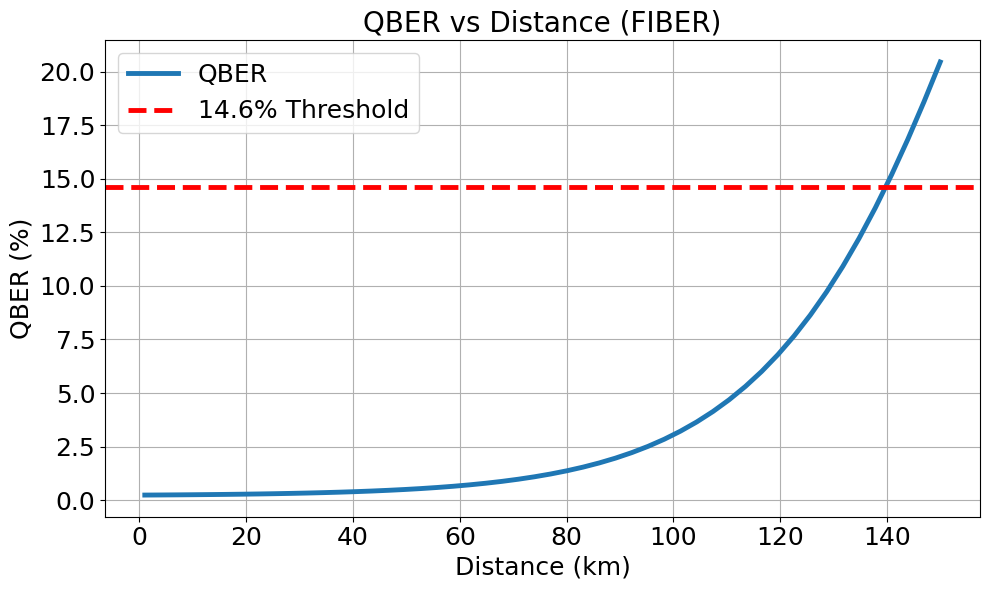

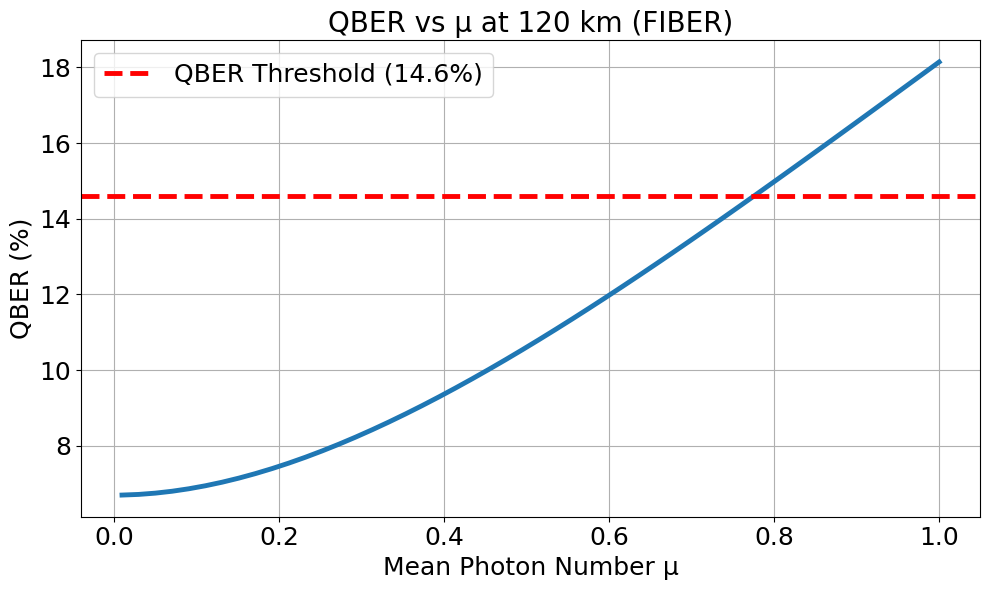

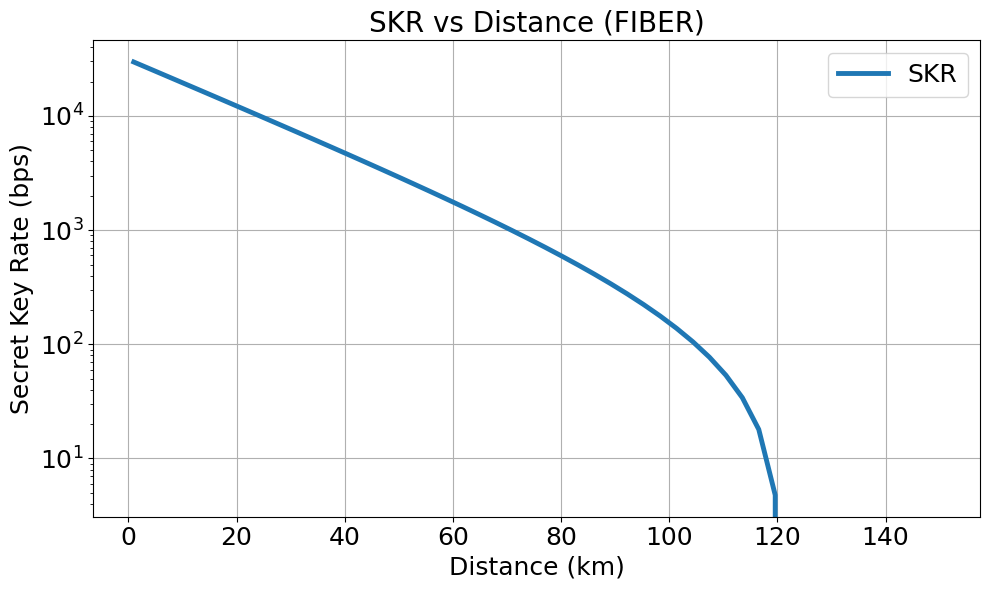

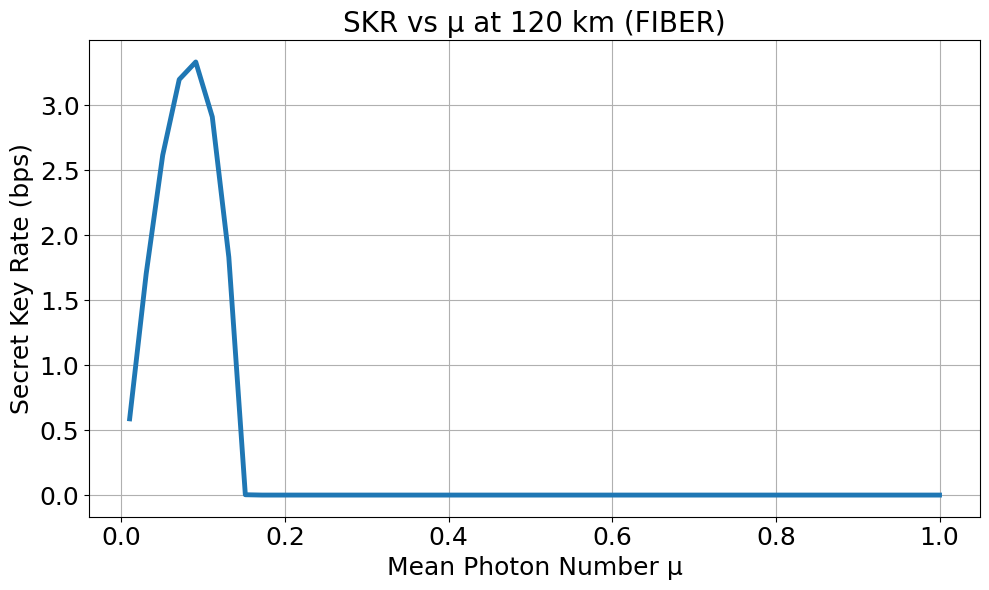

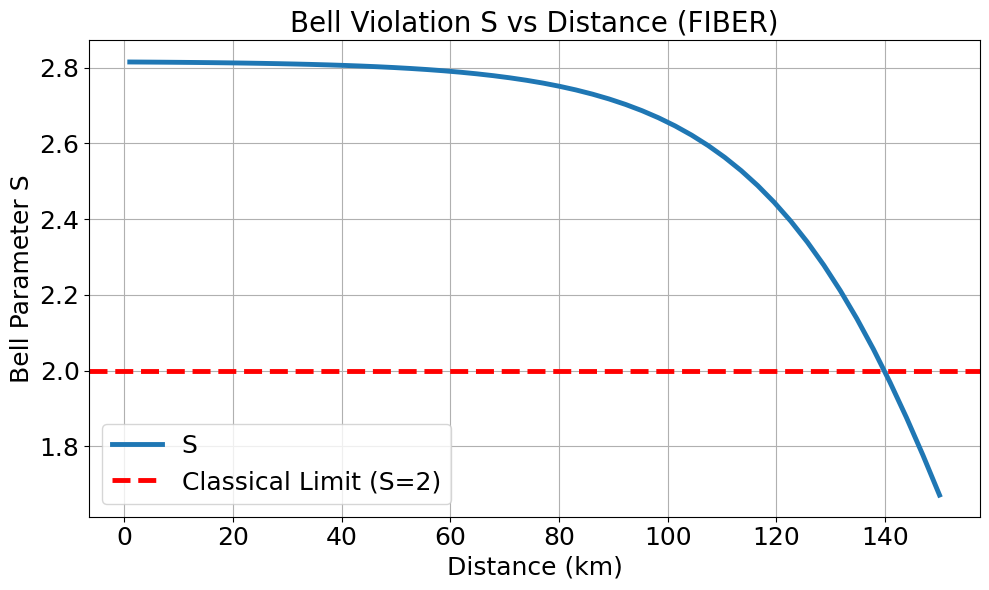

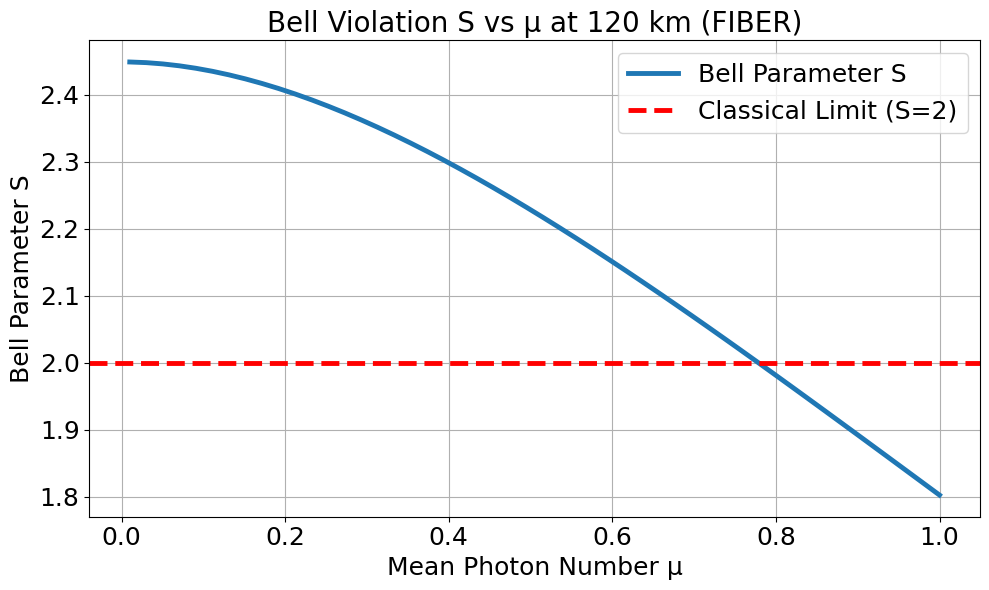

(array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
        0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
        0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
        0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
        0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
        0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
        0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
        0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
        0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
        0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ]),
 [np.float64(2.4492972523818093),
  np.float64(2.448323868897137),
  np.float64(2.4464095725171418),
  np.float64(2.443592391697965),
  np.float64(2.439909210070919),
  np.float64(2.4353957970251296),
  np.float64(2.4300868375247857),
  np.float64(2.424015961179378),
  np.float64(2.4172157705848694),
  np.float64(2.4

In [12]:
plot_qber_vs_distance()
plot_qber_vs_mu()
plot_skr_vs_distance()
plot_skr_vs_mu()
plot_bell_violation_vs_distance()
plot_bell_violation_vs_mu()

### Plotting graphs for fso mode :

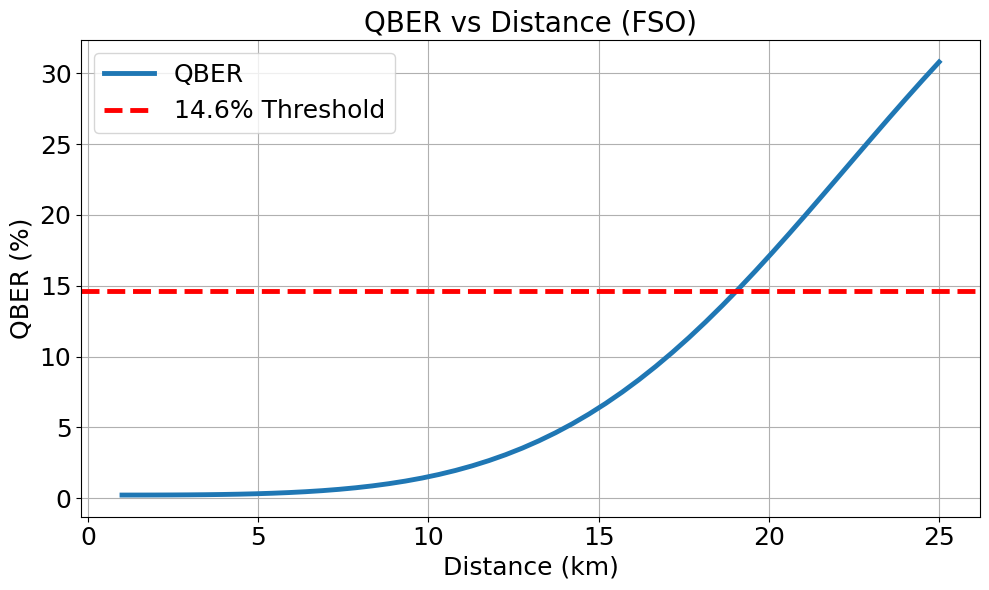

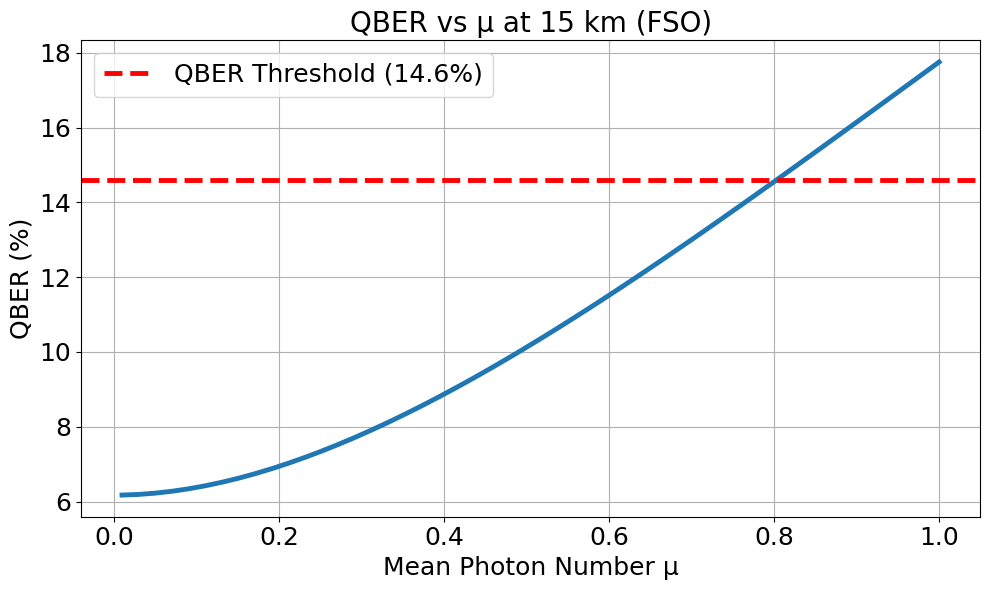

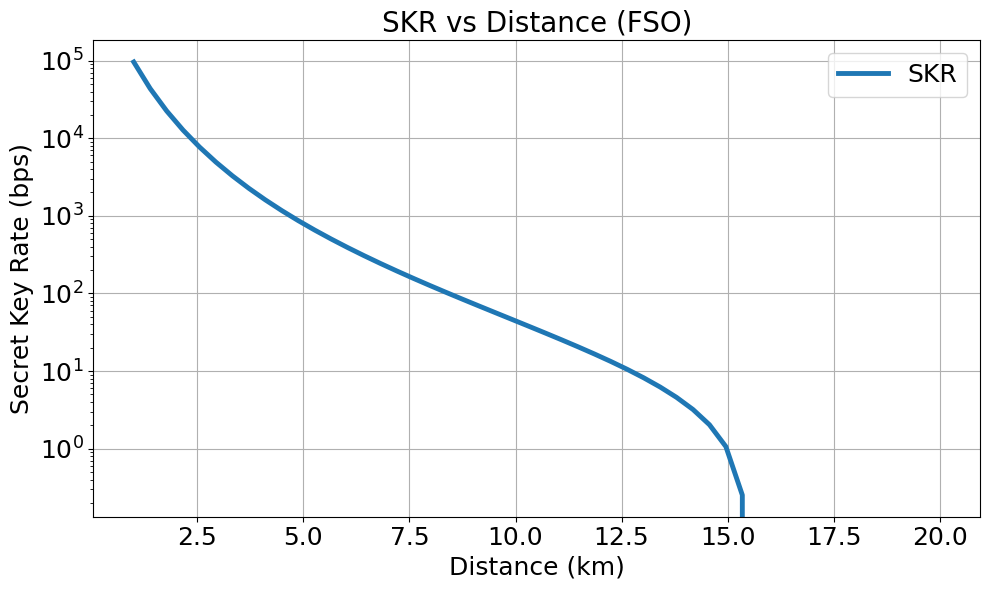

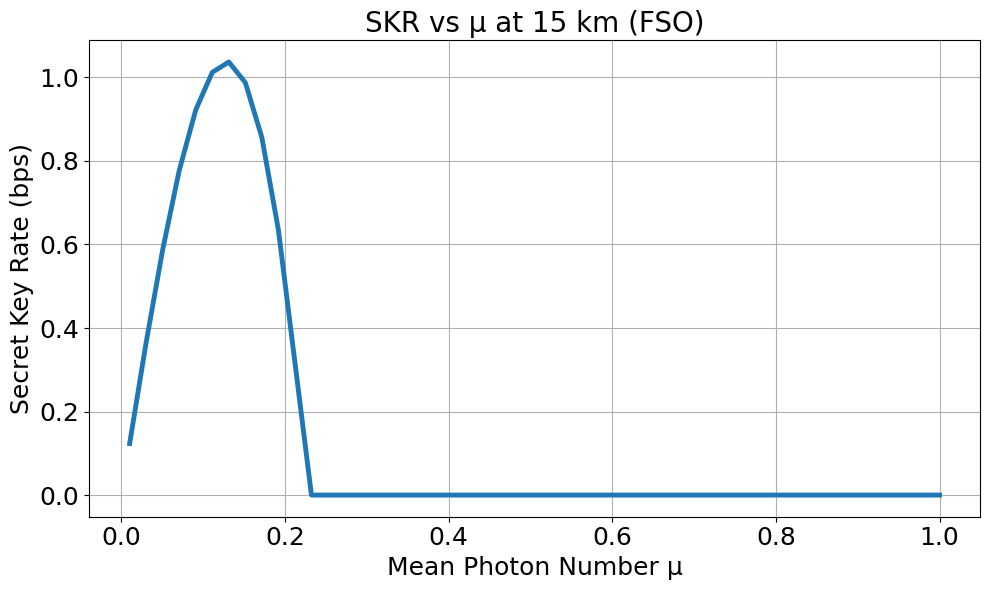

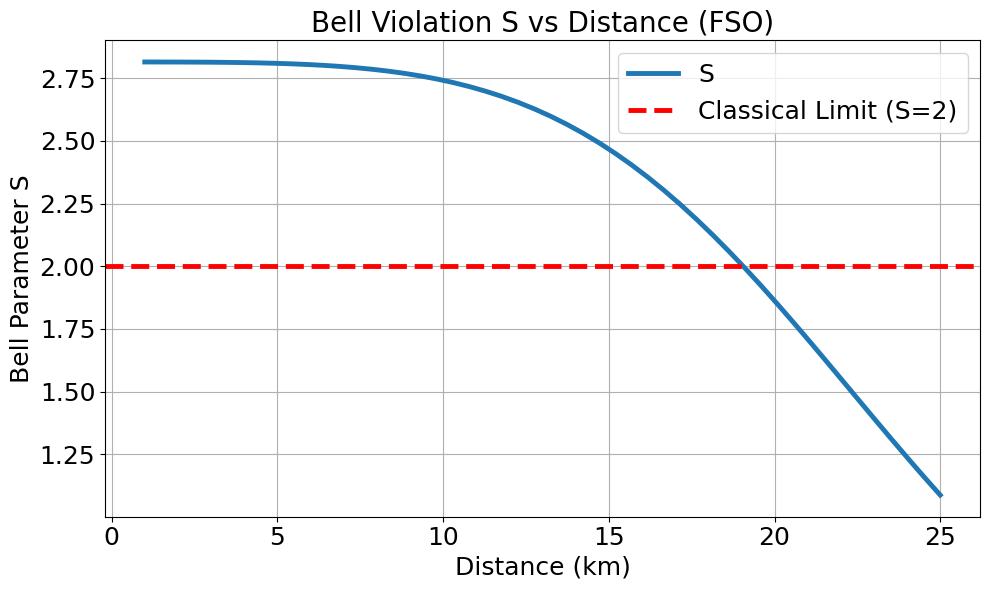

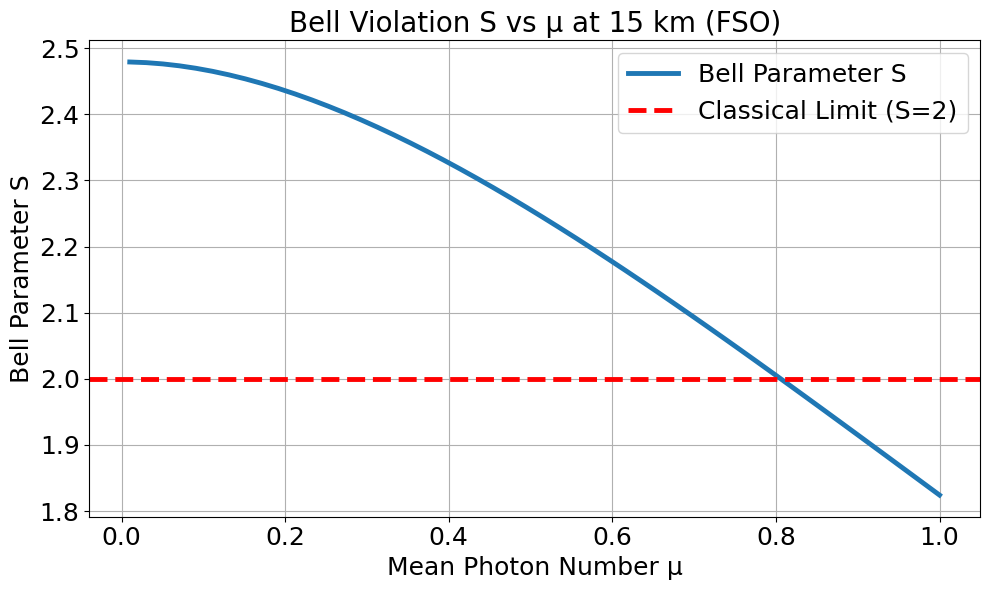

(array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
        0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
        0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
        0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
        0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
        0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
        0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
        0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
        0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
        0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ]),
 [np.float64(2.4792274132879153),
  np.float64(2.4782421351570174),
  np.float64(2.4763044462718367),
  np.float64(2.4734528397923454),
  np.float64(2.469724650064043),
  np.float64(2.4651560835743154),
  np.float64(2.459782249134054),
  np.float64(2.453637187303123),
  np.float64(2.4467538990778595),
  np.float64(2.

In [13]:
plot_qber_vs_distance(channel_type='fso',distance_range=(1,25))
plot_qber_vs_mu(channel_type='fso',fixed_distance_km=15)
plot_skr_vs_distance(channel_type='fso',distance_range=(1,20))
plot_skr_vs_mu(channel_type='fso',fixed_distance_km=15)
plot_bell_violation_vs_distance(channel_type='fso',distance_range=(1,25))
plot_bell_violation_vs_mu(channel_type='fso',fixed_distance_km=15)

##  E91 Simulator – Fiber vs FSO Distance-Based Comparison

This code compares the E91 quantum key distribution protocol's performance over **fiber** and **FSO** channels as a function of distance. It simulates QBER, Bell violations, SKR, and transmittance, and visualizes them in a 2×2 grid.

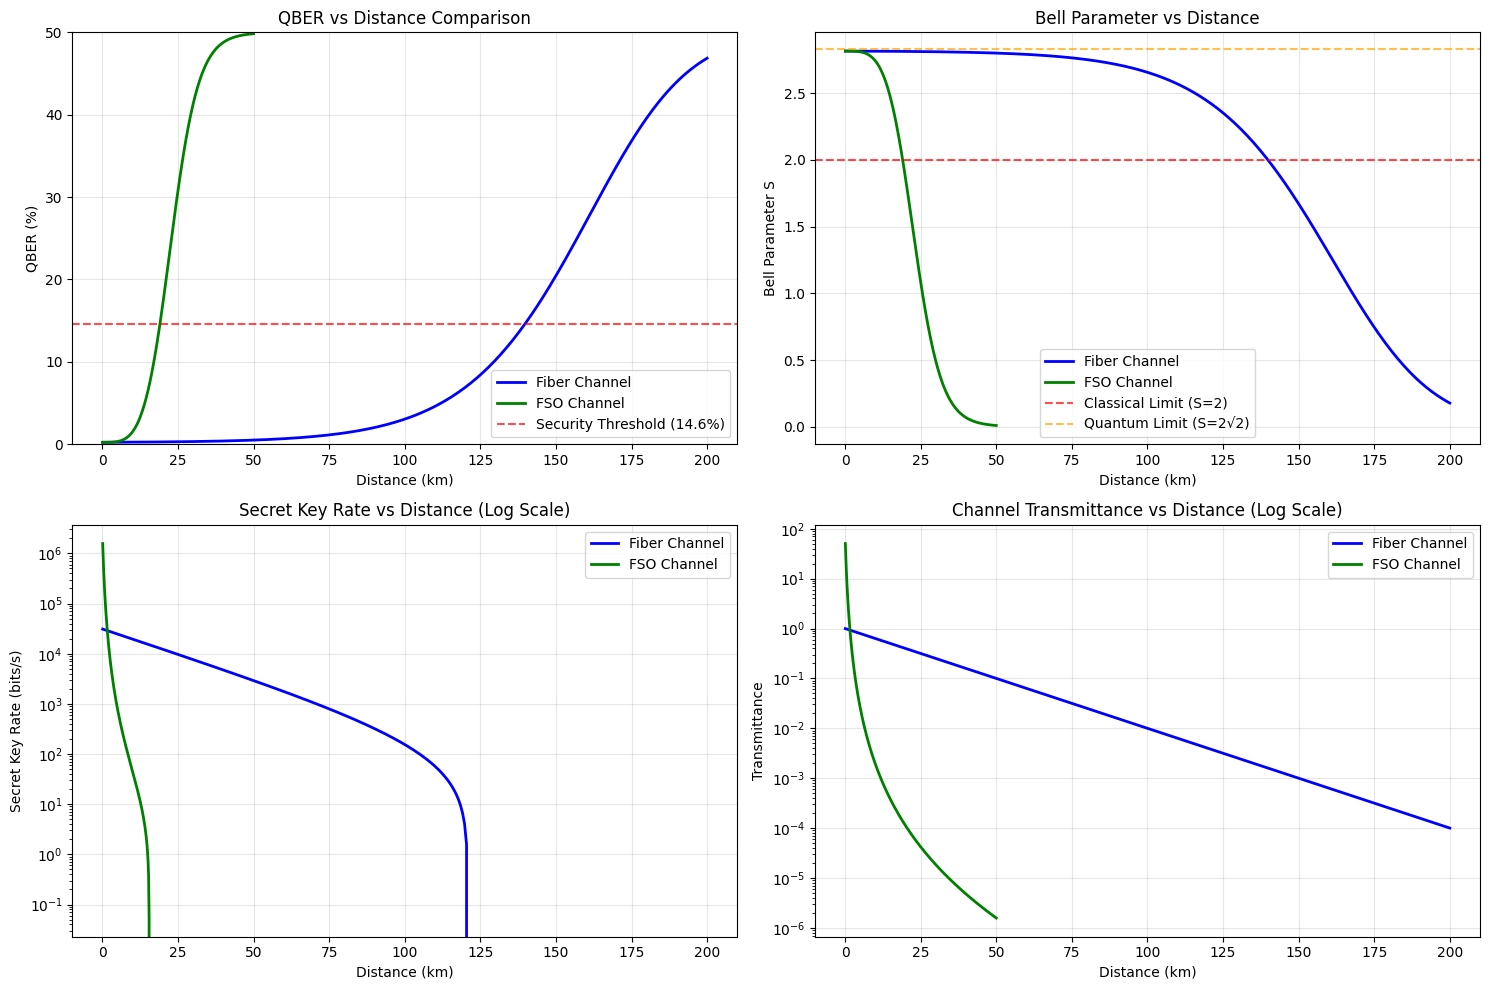

=== E91 QKD Simulation Results ===

Fiber Channel:
  Max distance simulated: 200.0 km
  QBER at max distance: 46.86%
  Bell parameter at max distance: 0.178

FSO Channel:
  Max distance simulated: 50.0 km
  QBER at max distance: 49.83%
  Bell parameter at max distance: 0.009

Fiber secure range: up to 139.2 km
FSO secure range: up to 19.0 km


In [ ]:
# Initialize channels and detector
fiber_channel = QuantumChannel(ChannelType.FIBER)
fso_channel = QuantumChannel(ChannelType.FSO)
detector = QuantumDetector()

# Initialize simulators (removed the invalid distance_km parameter)
mu = 0.1           # Mean photon number per pulse (adjustable)
f_rep = 1e6       # Pulse repetition rate in Hz

fiber_simulator = E91Simulator(fiber_channel, detector, distance_km=200, mu=mu, f_rep=f_rep)
fso_simulator = E91Simulator(fso_channel, detector, distance_km=50, mu=mu, f_rep=f_rep)

# Run simulations with custom distance ranges
# Fiber can go longer distances, FSO is limited
fiber_results = fiber_simulator.simulate_distance_range(min_distance=0.1, max_distance=200, num_points=300)
fso_results = fso_simulator.simulate_distance_range(min_distance=0.1, max_distance=50, num_points=300)

# Create comprehensive plotting
plt.figure(figsize=(15, 10))

# Plot 1: QBER vs Distance
plt.subplot(2, 2, 1)
plt.plot(fiber_results['distances'], fiber_results['qber_percents'], 
         label='Fiber Channel', color='blue', linewidth=2)
plt.plot(fso_results['distances'], fso_results['qber_percents'], 
         label='FSO Channel', color='green', linewidth=2)
plt.axhline(y=14.6, color='red', linestyle='--', alpha=0.7, label='Security Threshold (14.6%)')
plt.xlabel('Distance (km)')
plt.ylabel('QBER (%)')
plt.title('QBER vs Distance Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 50)  # Cap at 50% (theoretical maximum)

# Plot 2: Bell Parameter vs Distance
plt.subplot(2, 2, 2)
plt.plot(fiber_results['distances'], fiber_results['bell_parameters'], 
         label='Fiber Channel', color='blue', linewidth=2)
plt.plot(fso_results['distances'], fso_results['bell_parameters'], 
         label='FSO Channel', color='green', linewidth=2)
plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Classical Limit (S=2)')
plt.axhline(y=2*sqrt(2), color='orange', linestyle='--', alpha=0.7, label='Quantum Limit (S=2√2)')
plt.xlabel('Distance (km)')
plt.ylabel('Bell Parameter S')
plt.title('Bell Parameter vs Distance')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Secret Key Rate vs Distance
plt.subplot(2, 2, 3)
plt.semilogy(fiber_results['distances'], fiber_results['secret_key_rates'], 
             label='Fiber Channel', color='blue', linewidth=2)
plt.semilogy(fso_results['distances'], fso_results['secret_key_rates'], 
             label='FSO Channel', color='green', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Secret Key Rate (bits/s)')
plt.title('Secret Key Rate vs Distance (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Channel Transmittance vs Distance
plt.subplot(2, 2, 4)
plt.semilogy(fiber_results['distances'], fiber_results['transmittances'], 
             label='Fiber Channel', color='blue', linewidth=2)
plt.semilogy(fso_results['distances'], fso_results['transmittances'], 
             label='FSO Channel', color='green', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Transmittance')
plt.title('Channel Transmittance vs Distance (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key results
print("=== E91 QKD Simulation Results ===")
print(f"\nFiber Channel:")
print(f"  Max distance simulated: {fiber_results['distances'][-1]:.1f} km")
print(f"  QBER at max distance: {fiber_results['qber_percents'][-1]:.2f}%")
print(f"  Bell parameter at max distance: {fiber_results['bell_parameters'][-1]:.3f}")

print(f"\nFSO Channel:")
print(f"  Max distance simulated: {fso_results['distances'][-1]:.1f} km")
print(f"  QBER at max distance: {fso_results['qber_percents'][-1]:.2f}%")
print(f"  Bell parameter at max distance: {fso_results['bell_parameters'][-1]:.3f}")

# Find maximum secure distances
fiber_secure_distances = fiber_results['distances'][fiber_results['secure_regions']]
fso_secure_distances = fso_results['distances'][fso_results['secure_regions']]

if len(fiber_secure_distances) > 0:
    print(f"\nFiber secure range: up to {fiber_secure_distances[-1]:.1f} km")
else:
    print("\nFiber: No secure communication possible")

if len(fso_secure_distances) > 0:
    print(f"FSO secure range: up to {fso_secure_distances[-1]:.1f} km")
else:
    print("FSO: No secure communication possible")